In [14]:
import requests
from datetime import date, timedelta, datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns

In [15]:
#connecting api
from api_key import API_KEY


url = f"https://api.coingecko.com/api/v3/coins/bitcoin/market_chart" #api end point 

days_to_analyse = 2
currency = 'usd'

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": API_KEY
}

params = {
    'vs_currency' : currency,
    'days' : str(days_to_analyse)
}

response = requests.get(url, params=params, headers=headers)
data = response.json()

In [16]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [17]:
#extract prices
def load_token_prices(days, currency = 'usd', token = None):
    
    url = f"https://api.coingecko.com/api/v3/coins/{token}/market_chart"
    
    params = {
        'vs_currency': currency,
        'days': days
    }
    response = requests.get(url, params=params, headers=headers)
    data = response.json()

    prices = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
    prices['timestamp'] = pd.to_datetime(prices['timestamp'], unit='ms')
    prices.set_index('timestamp', inplace=True)

    return prices
    

In [18]:
#extract volumes
def load_token_volumes(days, currency = 'usd', token = None):
    
    url = f"https://api.coingecko.com/api/v3/coins/{token}/market_chart" 
    
    params = {
        'vs_currency': currency,
        'days': days
    }
    response = requests.get(url, params=params, headers=headers)
    data = response.json()

    volumes = pd.DataFrame(data['total_volumes'], columns=['timestamp', 'total_volume'])
    volumes['timestamp'] = pd.to_datetime(volumes['timestamp'], unit='ms')
    volumes.set_index('timestamp', inplace=True)

    return volumes

In [19]:
def calculate_volatility(prices, days):
    results = []
    for i in range(1, days + 1):  # loop to analyse each day hourly from selected (today-n) days until today
        day = datetime.today() - timedelta(days=i) 
        next_day = day + timedelta(days=1)

        daily = prices[(prices.index >= day) & (prices.index < next_day)] #new list with prices by day
        daily= daily.copy()
        daily['return'] = daily['price'].pct_change() # calculating hourly returns for every day
        volatility = daily['return'].std() # calculating volatility for every day in week
        
        results.append({ # adding result to new the empty list
           'date': day.date(), 
         'weekday' : day.strftime('%A'),
         'volatility' : volatility
    })

    df = pd.DataFrame(results)
    df['weekday'] = pd.Categorical(df['weekday'], categories=weekday_order, ordered=True)

    return df

In [20]:
def calculate_volume(volumes, days):
    results = []
    for i in range(1,days + 1):
        day = datetime.today() - timedelta(days=i)
        next_day = day + timedelta(days=1)

        daily = volumes[(volumes.index >= day) & (volumes.index < next_day)] #new list with total_volumes by day
        daily= daily.copy()
        sum_volume = daily['total_volume'].sum() # sum hourly volumes
        results.append({ # adding result to new the empty list
         'date': day.date(),
         'weekday' : day.strftime('%A'),
         'volume' : sum_volume
    })

    df = pd.DataFrame(results) 
    df['weekday'] = pd.Categorical(df['weekday'],categories=weekday_order, ordered=True) #set right order of weekdays (default alphabetical order)

    return df


Volatility of Bitcoin for last 11 hours:0.0068


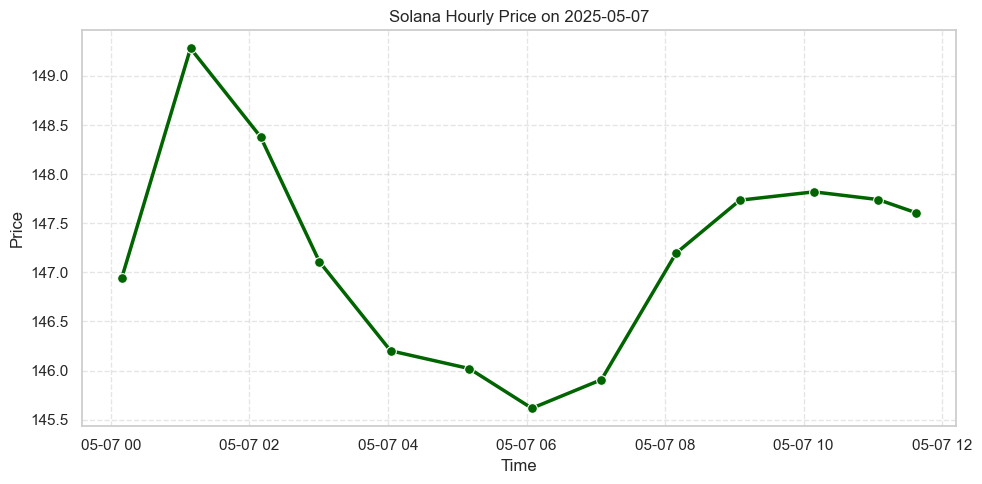

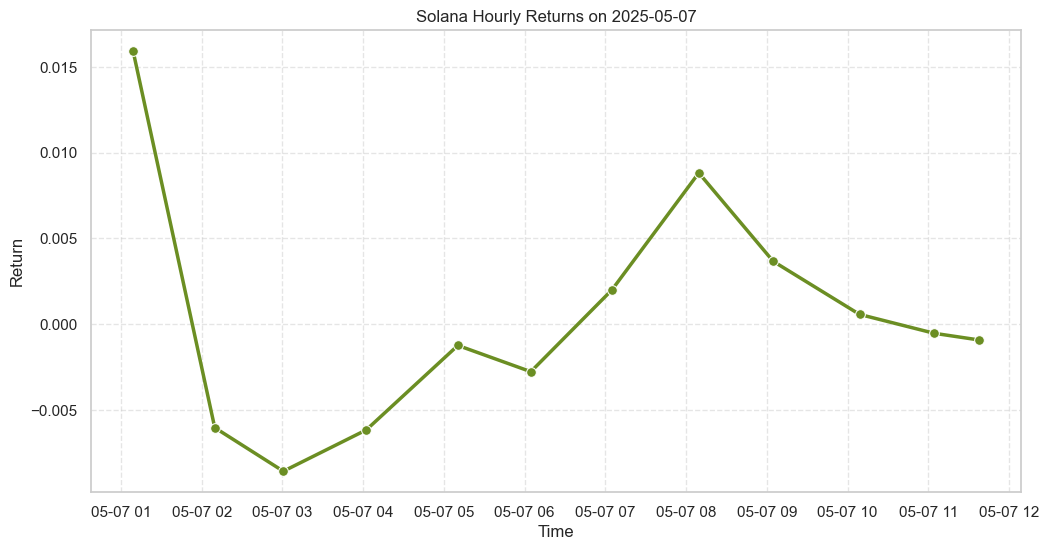

In [23]:
#Hourly Volatility

token =  'solana'

prices = load_token_prices(days = 2, token = token)
day_to_analyse = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 0,0,0) # setting today's datetime but resetting hours,mins and secs to zero
next_day = day_to_analyse + pd.Timedelta(days=1) # set the second day

prices = prices[(prices.index >= day_to_analyse) & (prices.index < next_day)] # deleting from dataset next_day to analyse only today's data hourly (default)
prices['return'] = prices['price'].pct_change() # calculate the percentage change from hour to hour (returns)
volatility = prices['return'].std() # calculate standard deviation of these returns (volatility)
#print(prices)

hours = max(prices.index.hour)
print(f'Volatility of Bitcoin for last {hours} hours:{volatility:.4f}')

plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid", palette="muted", font_scale=1)
sns.lineplot(data=prices, x=prices.index, y='price', linewidth=2.5, marker='o', markersize=7, color='darkgreen') # visualising price
plt.title(f'{token.capitalize()} Hourly Price on {day_to_analyse.date()}')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True, linestyle = '--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.lineplot(data=prices, x=prices.index, y='return', linewidth=2.5, marker='o', markersize=7, color='olivedrab')
plt.title(f'{token.capitalize()} Hourly Returns on {day_to_analyse.date()}')
plt.xlabel('Time')
plt.ylabel('Return')
plt.grid(True,linestyle='--', alpha=0.5)
plt.show()


In [ ]:
#Weekly Volatility 

days = 30
token = ''

prices = load_token_prices(days, token = token)

df = calculate_volatility(prices, days)

grouped = df.groupby('weekday', observed=True)['volatility'].mean().reset_index() # group calculated average volatilities by weekday

sns.set_theme(style='whitegrid', palette='bright', font_scale=1)
plt.figure(figsize=(10,5))
sns.barplot(data=grouped, x='weekday',y='volatility', color='royalblue' )
plt.title(f'Average Volatility of {token.capitalize()} by Day of week')
plt.xlabel('Weekday')
plt.ylabel('Volatility (std dev of Returns)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


KeyError: 'prices'

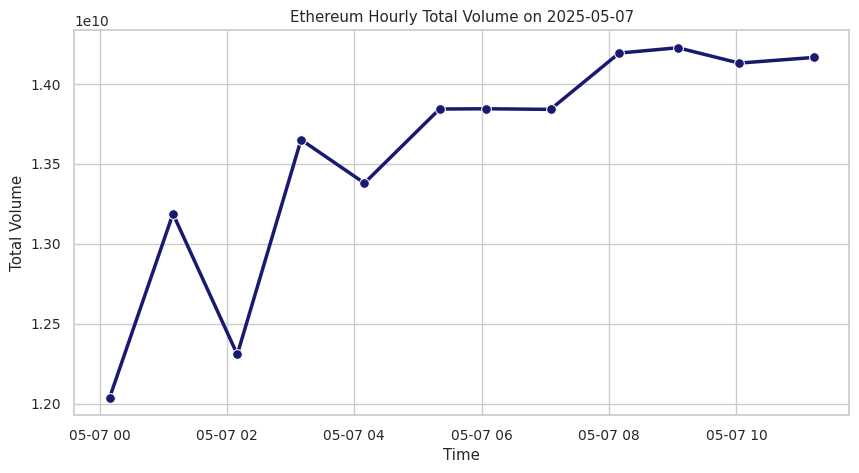

In [ ]:
#Hourly Total Volume
token = "ethereum"

volumes = load_token_volumes(days = 2, token = token)

day_to_analyse = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 0,0,0)
next_day = day_to_analyse + pd.Timedelta(days=1)
total_volumes = volumes[(volumes.index >= day_to_analyse) & (volumes.index < next_day)] 
#print(total_volumes)

plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid", palette="muted", font_scale=0.9)
sns.lineplot(data=total_volumes, x=total_volumes.index, y='total_volume', linewidth=2.5, marker='o', markersize=7, color='midnightblue')
plt.title(f'{token.capitalize()} Hourly Total Volume on {day_to_analyse.date()}')  # visualising price
plt.xlabel('Time')
plt.ylabel('Total Volume')
plt.grid(True)
plt.show()


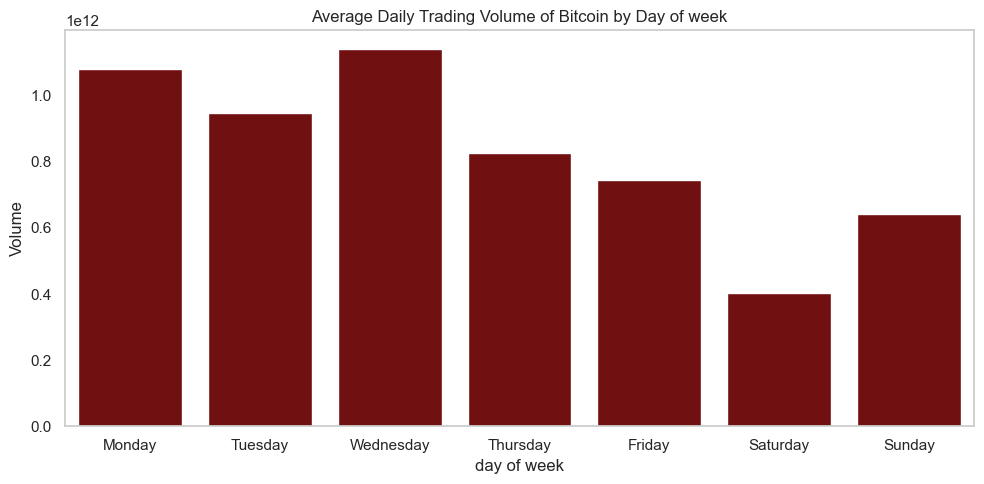

In [ ]:
#Weekly Total Volume

days = 30
token = ''

volumes = load_token_volumes(days, token = token)

df = calculate_volume(volumes,days)

grouped = df.groupby('weekday', observed=True)['volume'].mean().reset_index() # grouping and caclulating avg of volumes by weekday

sns.set_theme(style='whitegrid', palette='bright', font_scale=1)
plt.figure(figsize=(10,5))
sns.barplot(data=grouped, x='weekday',y='volume', color='maroon' )
plt.title(f'Average Daily Trading Volume of {token.capitalize()} by Day of week')
plt.xlabel('day of week')
plt.ylabel('Volume')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [24]:
#Correlation of Volume and Volatility

days = 30
token = ''

#extracting price data
prices = load_token_prices(days, token = token)

#extracting total volume data
volumes = load_token_volumes(days)

#calculating volatilily and volumes for each day
result_volume = calculate_volume(volumes, days)
result_volat = calculate_volatility(prices,days)

full_result = pd.merge(result_volume[['date', 'volume','weekday']], result_volat[['date','volatility']],on='date')

plt.figure(figsize=(10,6))
sns.regplot(x='volume', 
            y='volatility', 
            data=full_result, ci=95, 
            scatter_kws={'s' : 70, 'alpha' : 0.7}, 
            line_kws={'color': 'red', 'linestyle' : '--'})

plt.title(f'Correlation between Volume and Volatility of {token.capitalize()} (last {days} days)')
plt.xlabel('total volume')
plt.ylabel('volatility')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

corr , p_value = pearsonr(full_result['volume'], full_result['volatility'])
print(f'Correlation: {corr:4f}')
print(f'P_Value: {p_value:4f}')

KeyError: 'prices'

                         total_volume weekday  hour
timestamp                                          
2025-03-28 12:05:29.268  3.096078e+10  Friday    12
2025-03-28 13:04:45.166  3.169439e+10  Friday    13
2025-03-28 14:04:57.279  2.454702e+10  Friday    14
2025-03-28 15:05:36.116  2.856943e+10  Friday    15
2025-03-28 16:09:38.263  2.919431e+10  Friday    16
...                               ...     ...   ...
2025-04-27 08:05:24.098  1.689684e+10  Sunday     8
2025-04-27 09:04:57.311  1.603179e+10  Sunday     9
2025-04-27 10:00:03.880  1.574799e+10  Sunday    10
2025-04-27 11:06:23.248  1.552694e+10  Sunday    11
2025-04-27 12:19:51.000  1.542246e+10  Sunday    12

[721 rows x 3 columns]


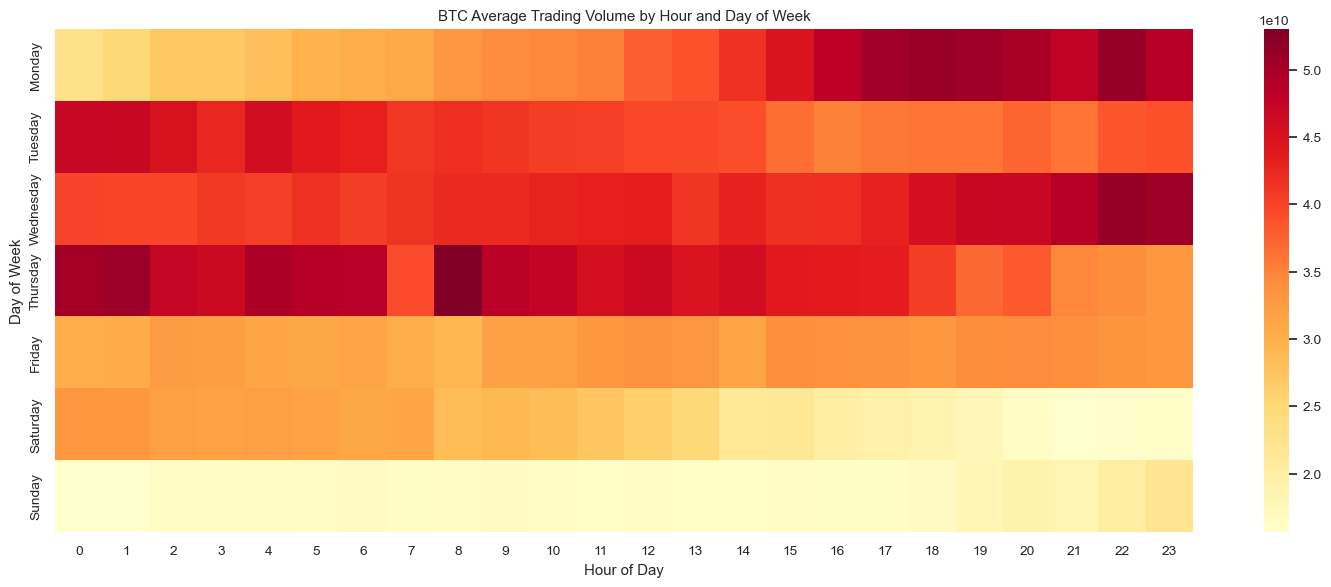

In [ ]:
#heatmap volume by hour and weekday

days = 30
token = ''

volumes = load_token_volumes(days, token = token)
volumes['weekday'] = volumes.index.day_name()
volumes['hour'] = volumes.index.hour
print(volumes)

pivot_table = volumes.pivot_table(index='weekday',columns='hour', values='total_volume', aggfunc='mean')
pivot_table = pivot_table.reindex(weekday_order)

plt.figure(figsize=(15,6))
sns.heatmap(pivot_table, cmap='YlOrRd')
plt.title(f'{token.capitalize()} Average Trading Volume by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()


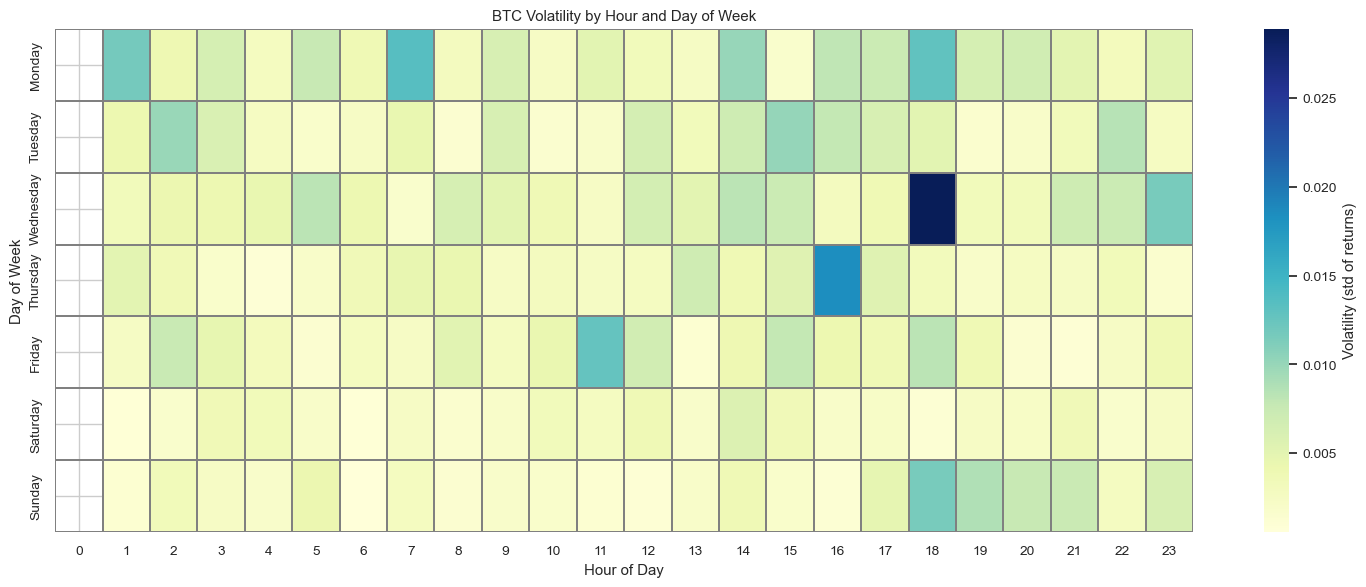

In [ ]:
#heatmap volatility by hour and weekday
days = 30
token = ''

prices = load_token_prices(days, token = token)
prices['weekday'] = prices.index.day_name()
prices['hour'] = prices.index.hour
prices['date'] = prices.index.date

prices['return'] = prices.groupby('date')['price'].pct_change()
vol_table = prices.groupby(['weekday','hour'])['return'].std().unstack()
vol_table= vol_table.reindex(weekday_order)

#print(vol_table)
plt.figure(figsize=(15,6))
sns.heatmap(vol_table, cmap='YlGnBu', annot=False, linewidths=0.3,linecolor='gray', cbar_kws={'label':'Volatility (std of returns)'})
plt.title(f'{token.capitalize()} Volatility by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

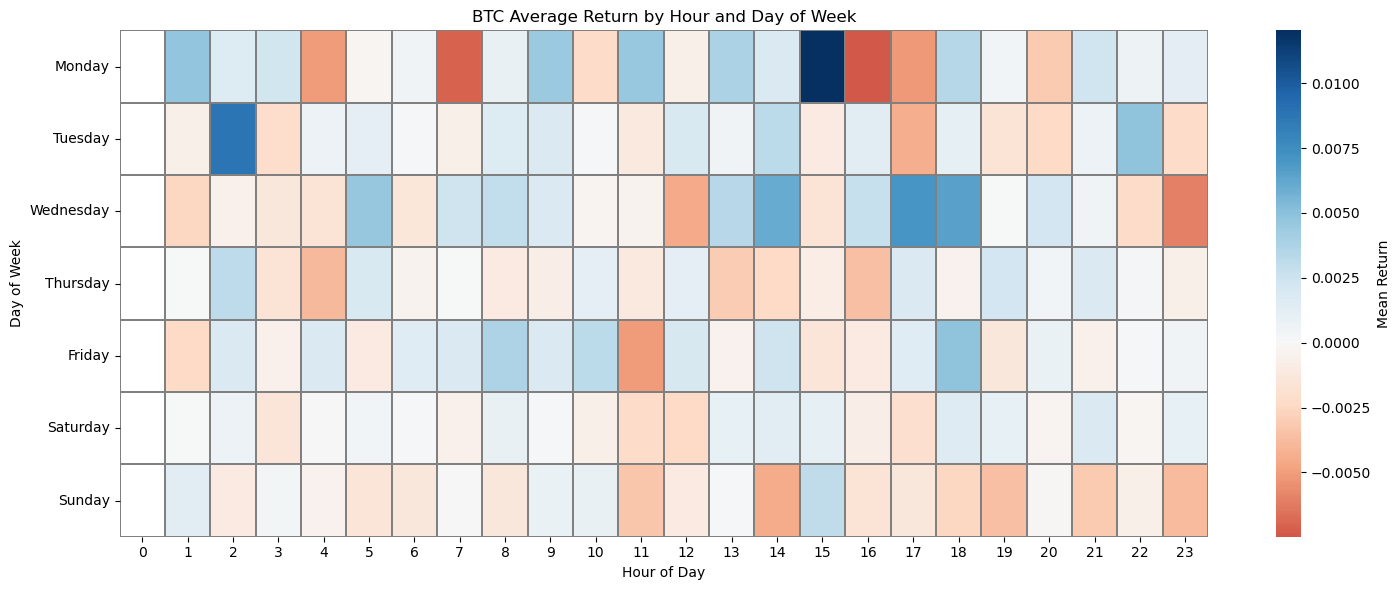

In [ ]:
#heatmap returns by hour and weekday

days = 30
token = '' 

prices = load_token_prices(days, token = token)
prices['weekday'] = prices.index.day_name()
prices['hour'] = prices.index.hour
prices['date'] = prices.index.date
prices['return'] = prices.groupby('date')['price'].pct_change()

returns_table= prices.groupby(['weekday','hour'])['return'].mean().unstack()
returns_table= returns_table.reindex(weekday_order) #set right order of weekdays (default alphabetical order)

plt.figure(figsize=(15,6))
sns.heatmap(returns_table, cmap='RdBu',center=0, annot=False, linewidths=0.3,linecolor='gray', cbar_kws={'label':'Mean Return'})
plt.title(f'{token.capitalize()} Average Return by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

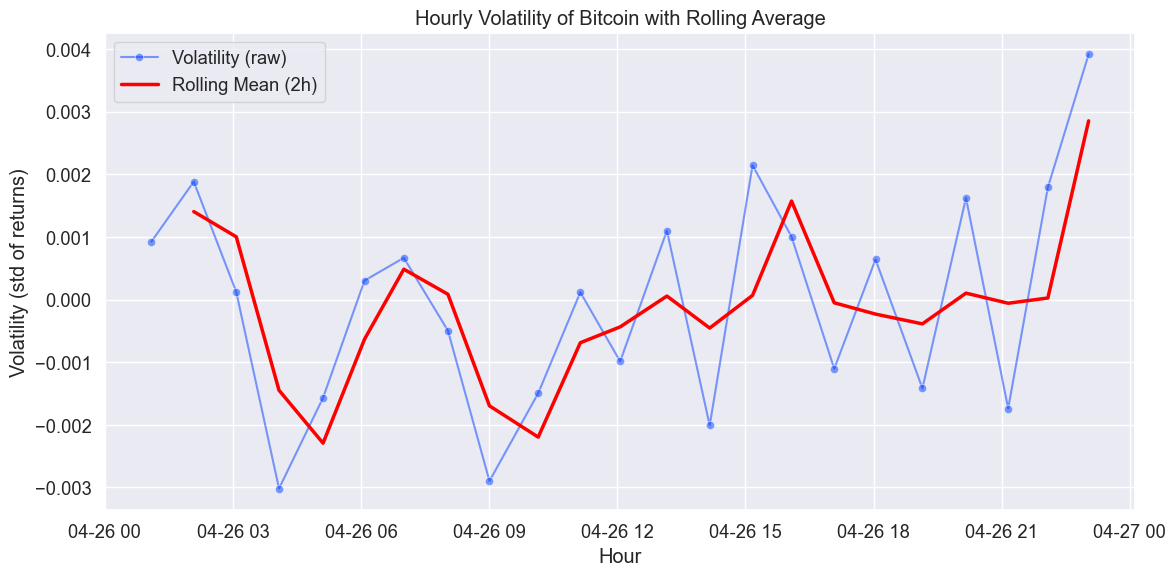

In [ ]:
#moving average volatility hourly

window = 2
token = ''

prices = load_token_prices(days=2, token = token )

yesterday = pd.Timestamp.today().normalize() - pd.Timedelta(days=1) #make analyse only for one day (here for yesterday)
today = pd.Timestamp.today().normalize()
df_day = prices[(prices.index >= yesterday) & (prices.index < today)].copy()

df_day['return'] = df_day['price'].pct_change()
df_day['vol'] = df_day['return'].std()
df_day['rolling_vol'] = df_day['return'].rolling(window=window).mean() #creating moving average with window 3

plt.figure(figsize=(12, 6))
sns.set_theme(style='darkgrid', palette='bright', font_scale=1.2)
sns.lineplot(x=df_day.index, y=df_day['return'], label='Volatility (raw)', marker='o', markersize=6, linewidth=1.5, alpha=0.5)
sns.lineplot(x=df_day.index, y=df_day['rolling_vol'], label=f'Rolling Mean ({window}h)', color='red', linewidth=2.5)
plt.title(f'Hourly Volatility of {token.capitalize()} with Rolling Average')
plt.xlabel('Hour')
plt.ylabel('Volatility (std of returns)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


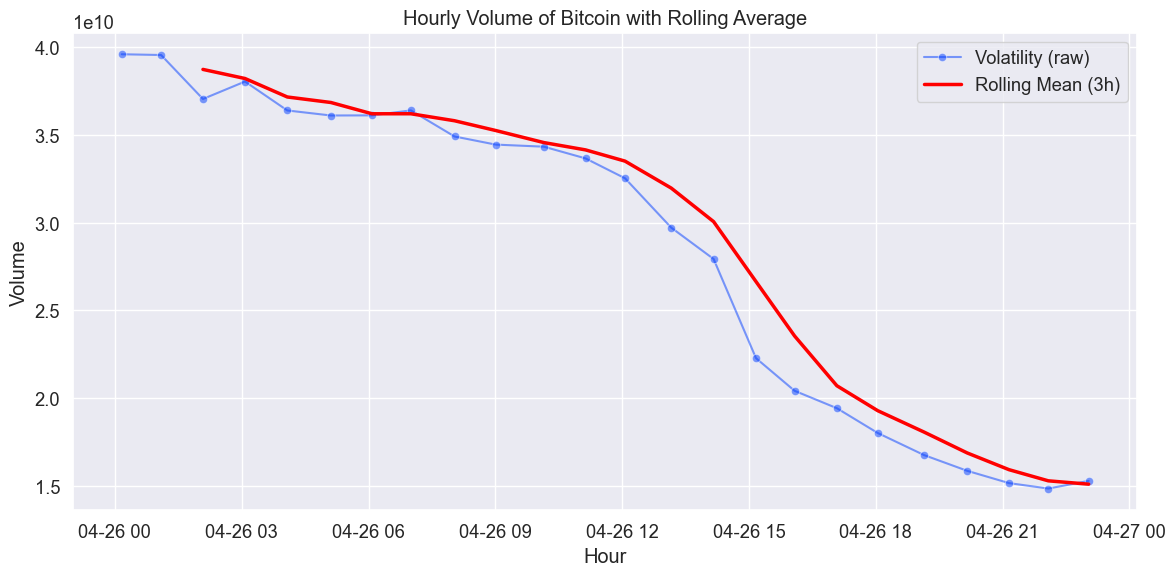

In [ ]:
#moving average volume hourly

window = 3
token = ''

volumes = load_token_volumes(days = 2, token = token)

yesterday = pd.Timestamp.today().normalize() - pd.Timedelta(days=1) #make analyse only for one day (here for yesterday)
today = pd.Timestamp.today().normalize()

df_day = volumes[(volumes.index >= yesterday) & (volumes.index < today)].copy()
df_day['rolling_volume'] = df_day['total_volume'].rolling(window=window).mean() #creating moving average with window 3

plt.figure(figsize=(12, 6))
sns.set_theme(style='darkgrid', palette='bright', font_scale=1.2)
sns.lineplot(x=df_day.index, y=df_day['total_volume'], label='Volatility (raw)', marker='o', markersize=6, linewidth=1.5, alpha=0.5)
sns.lineplot(x=df_day.index, y=df_day['rolling_volume'], label=f'Rolling Mean ({window}h)', color='red', linewidth=2.5)
plt.title(f'Hourly Volume of {token.capitalize} with Rolling Average')
plt.xlabel('Hour')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

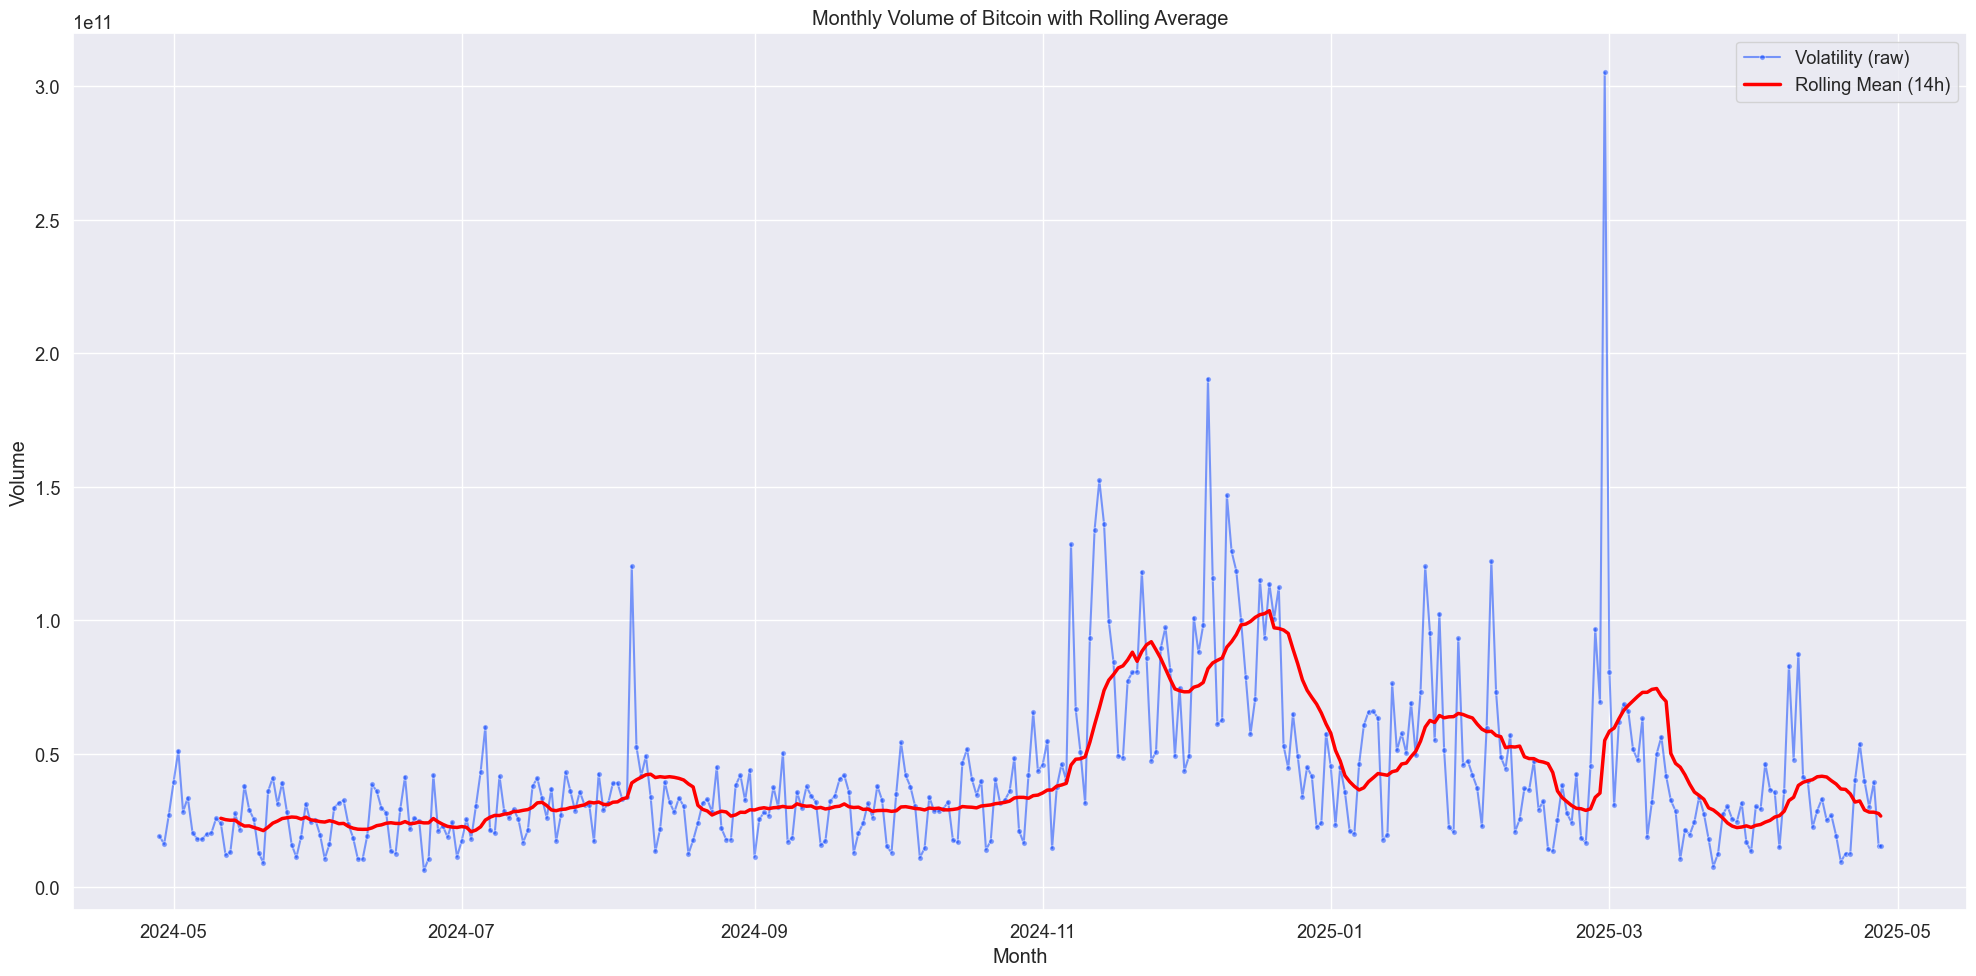

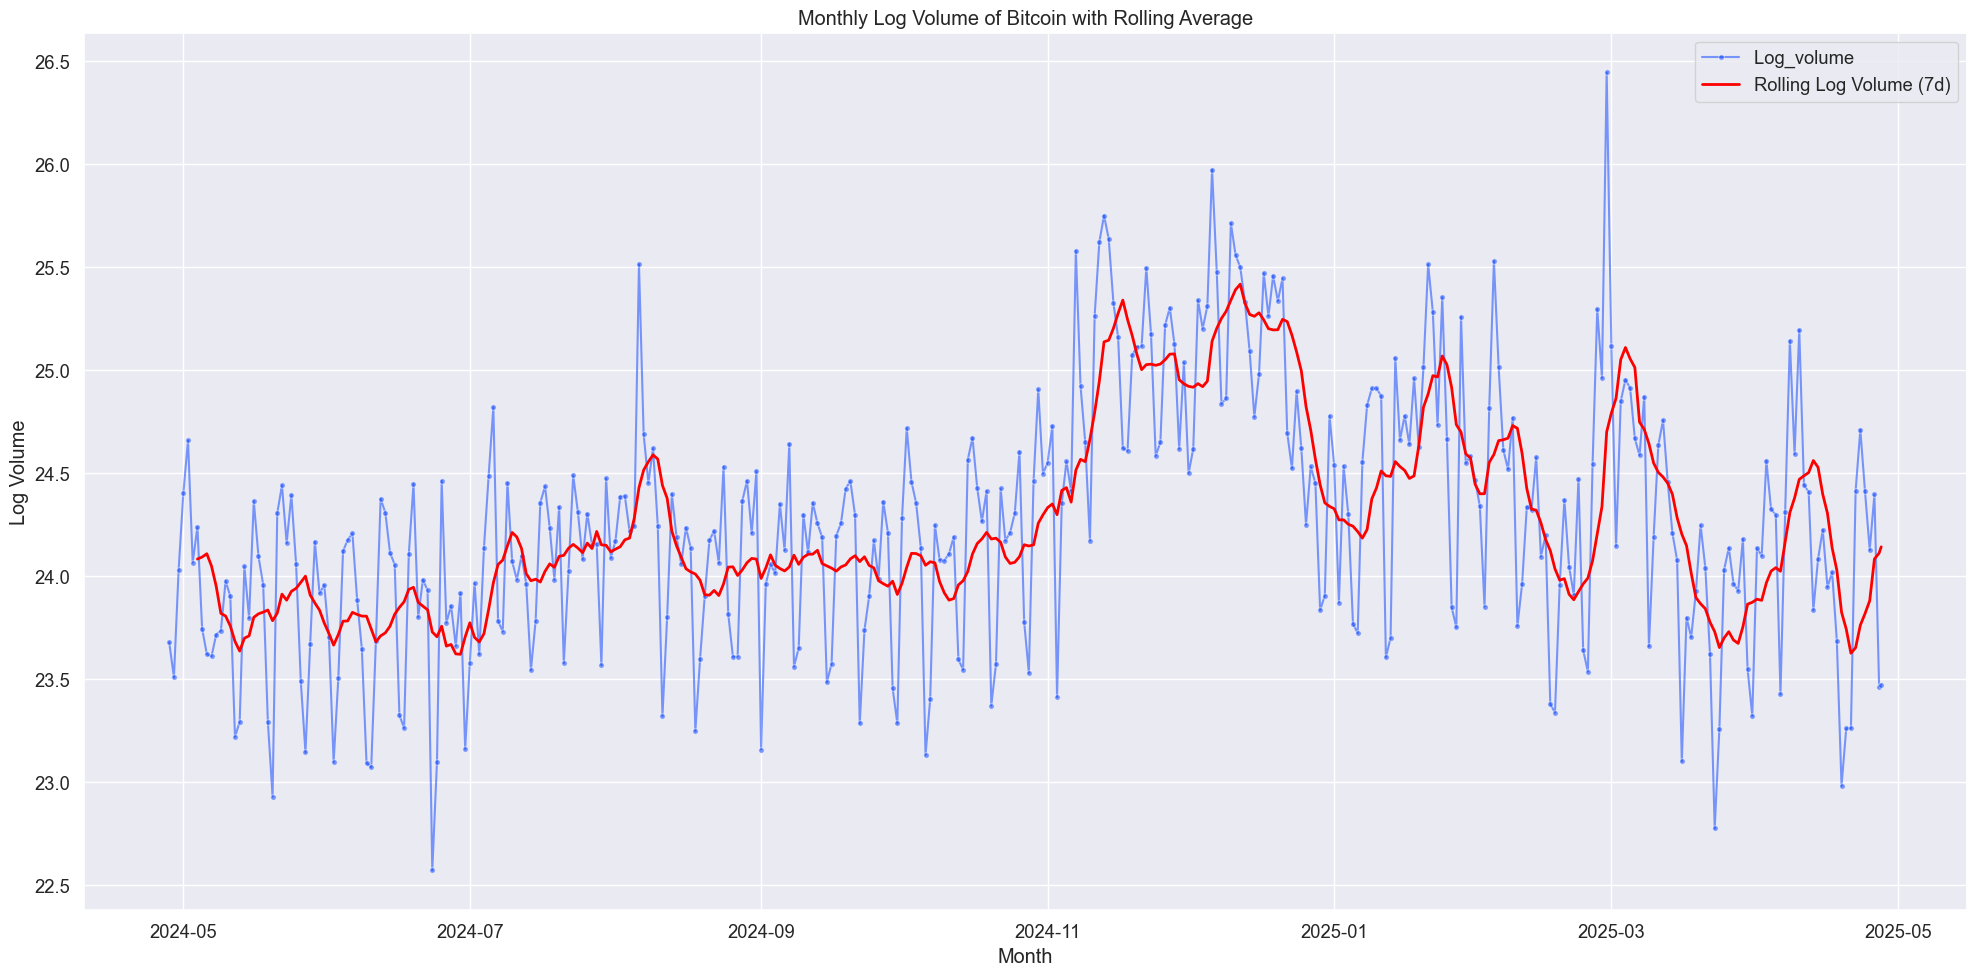

In [ ]:
#moving average volume for year

window_simple = 14
window_log = 7
token = ''

volumes = load_token_volumes(days = 365, token = token)

#print(volumes)
volumes['rolling_volume'] = volumes['total_volume'].rolling(window=window_simple).mean() #creating moving average with window 3
volumes['log_volume'] = np.log1p(volumes['total_volume'])
volumes['rolling_log_volume'] = volumes['log_volume'].rolling(window=window_log).mean()

plt.figure(figsize=(20, 10))
sns.set_theme(style='darkgrid', palette='bright', font_scale=1.2)
sns.lineplot(x=volumes.index, y=volumes['total_volume'], label='Volatility (raw)', marker='o', markersize=4, linewidth=1.5, alpha=0.5)
sns.lineplot(x=volumes.index, y=volumes['rolling_volume'], label=f'Rolling Mean ({window_simple}h)', color='red', linewidth=2.5)
plt.title(f'Monthly Volume of {token.capitalize()} with Rolling Average')
plt.xlabel('Month')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
sns.lineplot(x=volumes.index, y=volumes['log_volume'], label='Log_volume ',marker='o', markersize=4, linewidth=1.5, alpha=0.5)
sns.lineplot(x=volumes.index,y= volumes['rolling_log_volume'], label=f'Rolling Log Volume ({window_log}d)', color='red', linewidth=2)
plt.title(f'Monthly Log Volume of {token.capitalize()} with Rolling Average')
plt.xlabel('Month')
plt.ylabel('Log Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

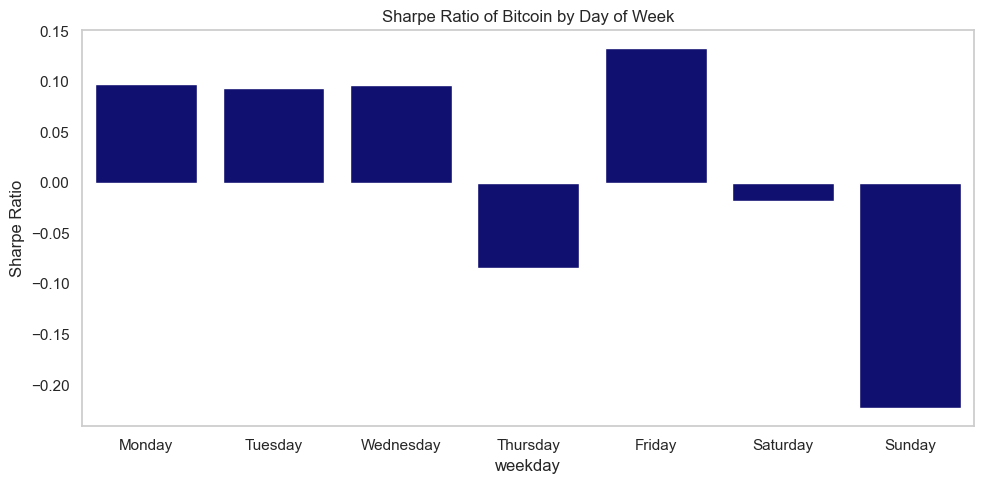

In [ ]:
# Sharpe Ratio by Weekday

days = 30
token =''

df_ratio = load_token_prices(days, token = token)
df_ratio['return'] = df_ratio['price'].pct_change()
df_ratio['weekday'] = df_ratio.index.day_name()

sharpe_by_day = df_ratio.groupby('weekday').agg( #grouping by weekday and calculating avg returns by weekday and volatility
    mean_return=('return', 'mean'),
    volatility=('return', 'std')
)

sharpe_by_day['sharpe_ratio'] = sharpe_by_day['mean_return'] / sharpe_by_day['volatility'] # calculating sharpe ratio for each weekday
sharpe_by_day = sharpe_by_day.loc[weekday_order]

plt.figure(figsize=(10,5))
sns.set_theme(style='whitegrid', palette='deep', font_scale=1)
sns.barplot(data=sharpe_by_day, x=sharpe_by_day.index,y='sharpe_ratio', color='navy' )
plt.title(f'Sharpe Ratio of {token.capitalize()} by Day of Week')
plt.ylabel('Sharpe Ratio')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


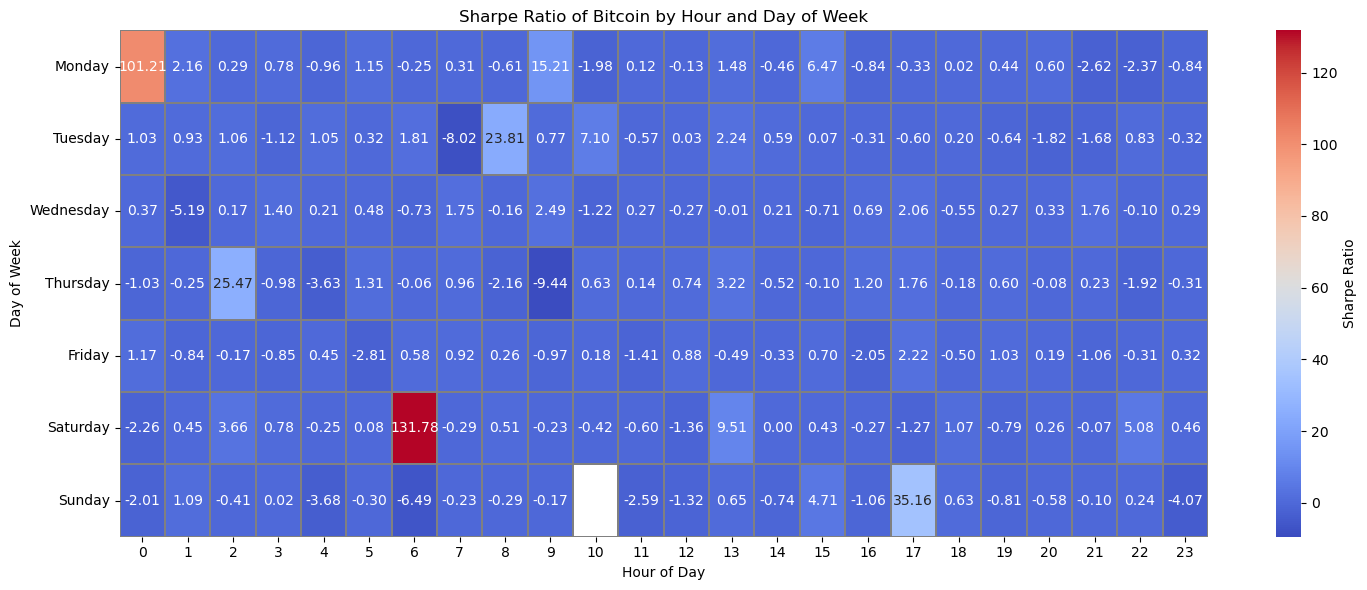

In [ ]:
# heatmap sharpe ratio

days = 14
token = '' 

prices = load_token_prices(days, token = token)
prices['return'] = prices['price'].pct_change()
prices['weekday'] = prices.index.day_name()
prices['hour'] = prices.index.hour

grouped = prices.groupby(['weekday', 'hour']).agg(
    mean_return=('return', 'mean'),
    volatility=('return', 'std')
)

grouped['sharpe_ratio'] = grouped['mean_return'] / grouped['volatility']

pivot_table = grouped['sharpe_ratio'].unstack()
pivot_table = pivot_table.reindex(weekday_order)


plt.figure(figsize=(15,6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.3, linecolor='gray', cbar_kws={'label': 'Sharpe Ratio'})
plt.title(f'Sharpe Ratio of {token.capitalize()} by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()